In [1]:
# compare models by plotting "decision boundaries" and number of boundaries

#imports
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from combo.models.classifier_comb import SimpleClassifierAggregator
from combo.models.classifier_stacking import Stacking
from combo.models.classifier_dcs import DCS_LA
from combo.models.classifier_des import DES_LA

In [2]:
# Define the number of class 0 and class 1.
n_samples = 300
class1_fraction = 0.5
clusters_separation = [3]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_class0 = int((1. - class1_fraction) * n_samples)
n_class1 = int(class1_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_class1:] = 1

# Show the statics of the data
print('Number of Class 0: %i' % n_class0)
print('Number of Class 1: %i' % n_class1)
print('Ground truth shape is {shape}.\n'.format(shape=ground_truth.shape))
print(ground_truth, '\n')

#create random state
random_state = np.random.RandomState(42)

#this seems to be pointless, but I included it regardless
classifiers = [LogisticRegression(), GaussianNB(), SVC(probability=True),
               KNeighborsClassifier()]

# Define some combination methods to be compared
classifiers = {

    'Logistic Regression': LogisticRegression(),
    'Gaussian NB': GaussianNB(),
    'Support Vector Machine': SVC(probability=True),
    'k Nearst Neighbors': KNeighborsClassifier(),
    'Simple Average': SimpleClassifierAggregator(base_estimators=classifiers,
                                                 method='average'),
    'Simple Maximization': SimpleClassifierAggregator(
        base_estimators=classifiers, method='maximization'),
    'Stacking': Stacking(base_estimators=classifiers, shuffle_data=True),
    'Stacking_RF': Stacking(base_estimators=classifiers, shuffle_data=True,
                            meta_clf=RandomForestClassifier(
                                random_state=random_state)),
    'DCS_LA': DCS_LA(base_estimators=classifiers),
    'DEC_LA': DES_LA(base_estimators=classifiers)
}

# Show all classifiers. iterate through and print each model
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)


Number of Class 0: 150
Number of Class 1: 150
Ground truth shape is (300,).

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1] 

Model 1 Logistic Regression
Model 2 Gaussian NB
Model 3 Support Vector Machine
Model 4 k Nearst Neighbors
Model 5 Simple Average
Model 6 Simple Maximization
Model 7 Stacking
Model 8 Stacking_RF
Model 9 DCS_LA
Model 10 DEC_LA


1 fitting Logistic Regression
2 fitting Gaussian NB
3 fitting Support Vector Machine
4 fitting k Nearst Neighbors
5 fitting Simple Average
6 fitting Simple Maximization
7 fitting Stacking
8 fitting Stacking_RF
9 fitting DCS_LA
10 fitting DEC_LA


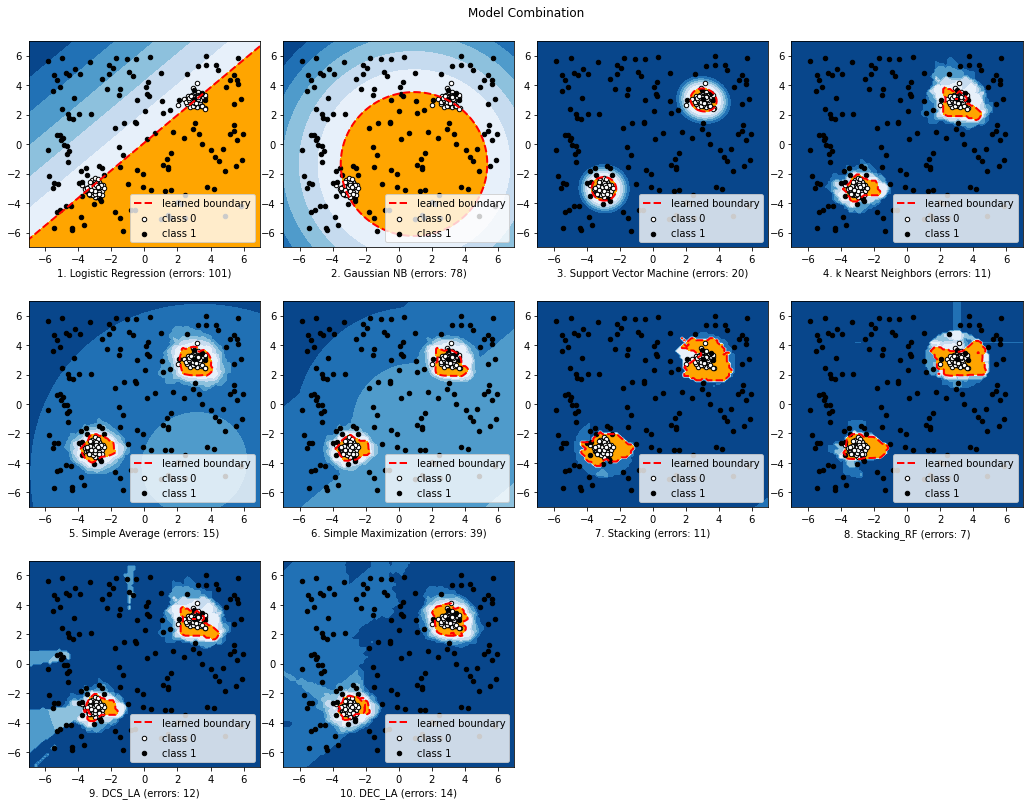

In [3]:
#this section contains majority of processing. iterates through each model and generates a graphic showing the decision boundaries

# Fit the models with the generated data and
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_class0 // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_class0 // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add class 1
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_class1, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag class 1

        clf.fit(X, ground_truth)
        scores_pred = clf.predict_proba(X)[:, 1] * -1

        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * class1_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_class1, 0], X[:-n_class1, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_class1:, 0], X[-n_class1:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned boundary', 'class 0', 'class 1'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Model Combination")
plt.savefig('compare_selected_classifiers.png', dpi=300)
plt.show()